In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin

import warnings

warnings.filterwarnings('ignore')


def load_csv(file_path, index_col='Id', parse_dates=True):
    df = pd.read_csv(file_path,  parse_dates=parse_dates, index_col='Id')
    return df

def delete_noise(X, indices):
    X.drop(indices, inplace = True, errors='ignore')
    X.reset_index(drop=True)    
    return

def get_irrilevant_cols(X, perc_treshold=90, fraction_total=2):
    row_count = X.shape[0]
    cols_to_delete = []
    for col in X.columns:
        values_counting = X[col].value_counts().reset_index().rename(columns={'index': 'val', col: 'counts'})
        top_values = values_counting.sort_values(by='count', ascending=False).head(2)
        perc_top= (top_values.iloc[0,1]/row_count)*100
        if(perc_top>perc_treshold):
            cols_to_delete.append(col)

        count = 0
        if (X[col].dtype == 'int64') or (X[col].dtype == 'float64'):
            count = X[X[col] > 0].shape[0]
        else:
            count = X[X[col].notna()].shape[0]

        if(count<row_count/fraction_total):
            cols_to_delete.append(col)

    return cols_to_delete

def find_outliers(X, col, quantile_param):
    if X[col].dtype in ['int64', 'float64']:  # Se la colonna è numerica
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if lower_bound<0:
            lower_bound=0
        print(f'lower and upper bound for {col}: {lower_bound} : {upper_bound}')
        outlier_indices = X[(X[col] < lower_bound) | (X[col] > upper_bound)].index
    
    elif X[col].dtype == 'object':  # Se la colonna è categoriale
        # Ottieni le frequenze delle categorie
        freq = X[col].value_counts(normalize=True)
        # Identifica le categorie che compaiono meno del 5% delle volte
        rare_categories = freq[freq < 0.05].index
        print(f'rare_categories for {col}: {rare_categories}')
        
        outlier_indices = X[X[col].isin(rare_categories)].index
    
    else:
        raise ValueError("Tipo di dati non supportato per la colonna: " + str(X[col].dtype))
    
    return outlier_indices.to_numpy()

def delete_outliers(X, outliers):
    for key in outliers:
        X.drop(key, inplace = True, errors='ignore')

def delete_outliers(X, outliers):
    for key in outliers:
        X.drop(key, inplace = True, errors='ignore')

    return X

def label_encode(X):
    le = LabelEncoder()
    return np.array([le.fit_transform(col) for col in X.T]).T  

def to_lowercase(df):
    return df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
    

def encode_with_custom_order(df, column_name, order_values):
    unique_values = [value.lower() if isinstance(value, str) else value for value in df[column_name].unique()]
    valid_values = [value.lower() for value in order_values if value in unique_values]
    return valid_values

def remove_original_columns(X):
    return X[:, -3:]  # Supponendo che l'output di svd abbia 3 colonne


def repair_nan(X, colname, mode='value', value=0):
        if isinstance(colname, str):
            colname = [colname]

        for col in colname:
            if col not in X.columns:
                print(f"{col} not found DataFrame.")
                continue

            if mode == 'value':
                X[col].fillna(value, inplace=True)
            elif mode == 'delrow':
                X.dropna(subset=[col], inplace=True)
            elif mode == 'mostcommon':
                most_common = X[col].mode()[0] 
                X[col].fillna(most_common, inplace=True)
            elif mode == 'mean':
                mean_value = X[col].mean()
                X[col].fillna(mean_value, inplace=True)
            elif mode == 'min':
                min_value = X[col].min()
                X[col].fillna(min_value, inplace=True)
            elif mode == 'max':
                max_value = X[col].max()
                X[col].fillna(max_value, inplace=True)
            elif mode == 'random_number':
                mean_value = X[col].mean()
                std_dev = X[col].std()  
                def is_nan(x):
                    return pd.isna(x)
                
                def random_error(x):
                    if is_nan(x):
                        return random.gauss(mean_value, 2 * std_dev) 
                    return x
            
                X[col] = X[col].apply(random_error)            
            else:
                print(f'{mode} not found')

        return


def correct_nan(X):
    # Correction for great missing values
    print('correction nan')
    repair_nan(X, colname='FireplaceQu', mode='value', value='NA') # Set to NA --> il campo viene eliminato comunque
    repair_nan(X, colname='MasVnrType', mode='value', value='NA') # Set to NA --> il campo viene eliminato comunque
    repair_nan(X, colname='LotFrontage', mode='value', value=0) # Set to 0 --> il campo viene eliminato comunque
    
    # Small corrections
    repair_nan(X, colname='MasVnrArea', mode='value', value=0) # Set to 0
    repair_nan(X, colname='BsmtQual', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtCond', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtExposure', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtFinType1', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='BsmtFinType2', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='Electrical', mode='mostcommon')  # most common
    repair_nan(X, colname='FireplaceQu', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageType', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageYrBlt', mode='value', value=0)  # Set to 0???
    repair_nan(X, colname='GarageFinish', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageQual', mode='value', value='NA') # Set to NA
    repair_nan(X, colname='GarageCond', mode='value', value='NA') # Set to NA
    
    return X


def get_coordinates(neighborhood):
    coordinates={}
    coordinates['Blmngtn']= [42.0220 , 93.6170]
    coordinates['Blueste']=[42.0145 , 93.6130]
    coordinates['BrDale']= [42.0188 , 93.6002 ]
    coordinates['BrkSide']=[42.0213 , 93.6178]
    coordinates['ClearCr']= [42.0240 , 93.6230] 
    coordinates['CollgCr']= [42.0315 , 93.6157] 
    coordinates['Crawfor']= [42.0236 , 93.6229]
    coordinates['Edwards']= [42.0212 , 93.6095] 
    coordinates['Gilbert']= [42.0420 , 93.6378]
    coordinates['IDOTRR']=[42.0330 , 93.5900] 
    coordinates['MeadowV']= [42.0140 , 93.6155]
    coordinates['Mitchel']= [42.0332 , 93.6053] 
    coordinates['NAmes']= [42.0270 , 93.6145] 
    coordinates['NoRidge']=[42.0290 , 93.5988]
    coordinates['NPkVill']= [42.0278 , 93.5867]
    coordinates['NridgHt']=[42.0255 , 93.5935 ]
    coordinates['NWAmes']= [42.0312 , 93.6293]
    coordinates['OldTown']=[42.0293 , 93.6171]
    coordinates['SWISU']= [42.0214 , 93.6178] 
    coordinates['Sawyer']= [42.0080, 93.6290 ]
    coordinates['SawyerW']=[42.0065 , 93.6280]
    coordinates['Somerst']= [42.0240 , 93.6050] 
    coordinates['StoneBr']= [42.0290 , 93.6160 ]
    coordinates['Timber']= [42.0350 , 93.5990] 
    coordinates['Veenker']= [42.0358 , 93.6340]
    
    return coordinates[neighborhood]

class TargetEncoder:
    
    def __init__(self, weight=0.7):
        self.weight = weight
        self.neighborhood_mean_all = None  # Media globale del target
        self.neighborhood_mean = None  # Media globale del target
        self.neighborhood_encoded  = {}   # Memorizza la media calcolata sul training        
        return
        

    def fit(self, X, y=None):
        if y is not None:  # Considera solo se il target è presente (training)
            X['SalePrice_per_footsqr'] = y/(X[['1stFlrSF', '2ndFlrSF']].sum(axis=1))

            self.neighborhood_mean_all = X['SalePrice_per_footsqr'].mean()
            self.neighborhood_mean = X.groupby('YrSold')['SalePrice_per_footsqr'].mean().reset_index(name='neighborhood_mean')
            grouped = X.groupby(['Neighborhood', 'YrSold']).agg({'SalePrice_per_footsqr': ['mean', 'count']})
            grouped.columns = ['mean', 'count']
            grouped.reset_index(inplace=True)
            grouped = grouped.merge(self.neighborhood_mean, on='YrSold')
            grouped['price_mean_nbrhd'] = (self.weight * grouped['mean']) + ((1-self.weight) * self.neighborhood_mean_all)
            self.neighborhood_encoded = grouped.set_index(['Neighborhood', 'YrSold'])['price_mean_nbrhd'].to_dict()

            # Cancello i due campi di utilità appena creati
            X.drop(columns=['SalePrice_per_footsqr'], inplace=True)

        return X

    def transform(self, X):
        X['price_mean_nbrhd'] = X.apply(
            lambda row: self.neighborhood_encoded.get((row['Neighborhood'], row['YrSold']), None), axis=1
        )
        X['price_mean_nbrhd'].fillna(self.neighborhood_mean_all)        
        return X

    def fit_transform(self, X, y):
        self.fit(X, y)
        self.transform(X)
        return X

  



# Estendo la classe onehot per inserire l'unknown
# Posso anche ridurre il numero di colonne tramite percentuale limite per categorie rare
class OneHotWithOther(BaseEstimator, TransformerMixin):
    def __init__(self, column_names, perc_thresholdOther=0.05):
        if not isinstance(column_names, list):
            raise ValueError("column_names deve essere una lista di nomi di colonne.")
        
        self.column_names = column_names
        self.perc_thresholdOther = perc_thresholdOther
        self.category_dict = {}
        self.other_category = 'other'

    def fit(self, X, y=None):
        countRows = X.shape[0]
        tresholdForCol = countRows * self.perc_thresholdOther
        #print(f'threshold:{tresholdForCol}')
        for column in self.column_names:
            if column not in X.columns:
                raise ValueError(f"La colonna {column} non esiste nel DataFrame.")
            
            possibleCategories = pd.Series(X[column]).unique()
            categToAdd = []
            for cat in possibleCategories:
                conteggiCat = X[X[column] == cat].shape[0]
                if  conteggiCat > tresholdForCol:
                    categToAdd.append(cat)
                    
            self.category_dict[column]=categToAdd
#            print(f'self.category_dict[column]: {self.category_dict[column]}')  
        
        return self

    def transform(self, X):
        X_transformed = X.copy()
        
        for column in self.column_names:
            if column not in self.category_dict:
                raise RuntimeError(f"Il fit deve essere eseguito per {column} prima di chiamare transform.")

            # Crea una colonna 'other'
            is_other = ~X[column].isin(self.category_dict[column])
            one_hot = pd.get_dummies(X[column].where(~is_other, other=self.other_category), prefix=column, prefix_sep='_')
            
            # Aggiungi la colonna "other"
            #one_hot[self.other_category] = is_other.astype(int)

            # Rimuovi la colonna originale e unisci le colonne one-hot
            X_transformed = pd.concat([X_transformed.drop(columns=[column]), one_hot], axis=1)
        #print(f'X_transformed:{X_transformed.columns}')
        return X_transformed


class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        return X.applymap(lambda s: s.lower() if isinstance(s, str) else s)


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

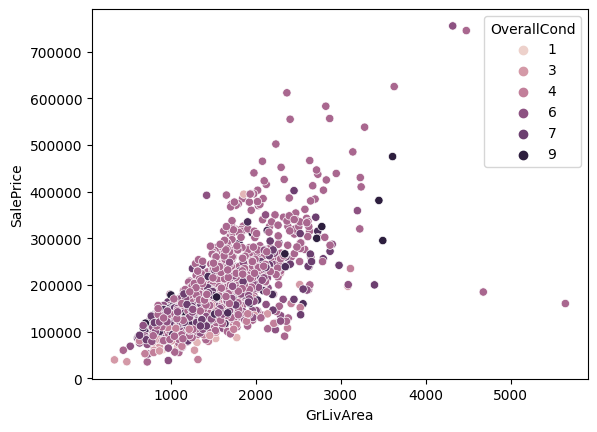

In [3]:
X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')

# Ripristinare l'opzione (se necessario)
pd.reset_option('display.max_columns')

# Configurare l'opzione per mostrare tutte le colonne
pd.set_option('display.max_columns', None)

sns.scatterplot(data=X, x='GrLivArea', y='SalePrice', hue='OverallCond')
#X[(X['LotArea']>150000) & (X['SalePrice']<400000)]
#X[(X['GrLivArea'].between(1786,2144))].groupby("OverallQual").SalePrice.mean()
#277000,375000,228950



**IRRILEVANT COLS AND OUTLIERS**

In [4]:
# Cerco gli ouliers solamente per le categorie che mi interessano
fields = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'KitchenQual', 'BsmtQual',
       'ExterQual', 'MSSubClass', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt',
       'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'LotFrontage', 'GarageType',
       'FireplaceQu', 'Foundation', 'OpenPorchSF', 'Fireplaces', 'HeatingQC',
       'Exterior2nd', '2ndFlrSF', 'BsmtFinType1', 'BsmtFinSF1', 'Exterior1st',
       'MSZoning', 'OverallCond', 'BsmtUnfSF', 'WoodDeckSF']

In [5]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer


X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
######################################################################################

##  OCCORRE TRASFORMARE IN STRINGA TUTTI I CAMPI CHE DI FATTO SONO CATEGORIE MA NON HANNO CONCETTO DI ORDINAMENTO
##  OPPURE DI DISTANZA

## TUTTE LE FEATURES CHE RAPPRESENTANO UN ORDINE VANNO TRASFORMATE IN ORDINAL ENCODING

## ANNO COSTRUZIONE e RISTRUTTURAZIONE DI PER SE' VOGLIONO DIRE POCO SE NON E' COMBINATO CON ANNO VENDITA, andrebbero quindi sottratti
## QUESTO VALE PER TUTTI GLI ANNI


## CREARE VARIABILI QUALITA' QUANTITA' --> normalizzare prima di moltiplicare oppure creare qualità proporzionale
## Qualità/numero elementi
## LO STESSO VALE Per Tipologia*area nel momento in cui la tipologia sia ordinabile per qualità
## MasVnrArea + (5000)*MasVnrType   dove MasVnrType=1,2,3 se MasVnrType=BrkCmm,BrkFace,Stone

## Qualità e condizioni può essere considerata come media ponderata qualitàtotale = w * qualità + (1-w) condizioni
## Oppure semplicemente moltiplicandole

# PRIMA DI DEFINIRE UNA COLONNA IRRILEVANTE OCCORRE CAPIRE SE HA RELAZIONI CON ALTRE FEATURES
# irrilevant_cols:['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 
# 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 
# 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 
# 'PoolArea', 'MiscVal', 'SaleType']
# SE VEDO CHE ESISTE UNA CORRELAZIONE MA QUESTA CORRELAZIONE NON PORTA NULLA HA SENSO ELIMINARE ANCHE ALTRE COLONNE?


######################################################################################
'''
features_engeneered = ['MSSubClass','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt',
                      '1stFlrSF','2ndFlrSF','BsmtUnfSF','GarageArea','MasVnrArea','MasVnrType',
                      #'Heating','HeatingQC',
                      'BsmtFullBath', 'BsmtHalfBath',
                      'FullBath', 'HalfBath'] #,'LowQualFinSF'
mi_higher01 = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'KitchenQual', 'ExterQual',
       'BsmtQual', '1stFlrSF', 'YearRemodAdd', 'MSSubClass', 'GarageFinish',
       'FullBath', 'GarageYrBlt', 'LotFrontage', 'FireplaceQu', 'GarageType',
       'TotRmsAbvGrd', 'Foundation', 'OpenPorchSF', 'Fireplaces', '2ndFlrSF',
       'HeatingQC', 'BsmtFinSF1', 'Exterior2nd', 'BsmtFinType1', 'MSZoning',
       'Exterior1st', 'BsmtUnfSF', 'OverallCond', #01
       'MasVnrType','LotShape','SaleCondition','SaleType', 'GarageCond', 'GarageQual']
'''
mi_higher01 = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'KitchenQual', 'BsmtQual',
       'ExterQual', 'MSSubClass', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt',
       'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'LotFrontage', 'GarageType',
       'FireplaceQu', 'Foundation', 'OpenPorchSF', 'Fireplaces', 'HeatingQC',
       'Exterior2nd', '2ndFlrSF', 'BsmtFinType1', 'BsmtFinSF1', 'Exterior1st',
       'MSZoning', 'OverallCond', 'BsmtUnfSF', 'WoodDeckSF']

features_engeneered = ['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
                      '1stFlrSF','2ndFlrSF','Neighborhood']

features_oneHot = [ 'GarageCars'
                    'MSSubClass', 
                   'GarageType',
                   'Foundation',
#                   'SaleType', 
#                   'SaleCondition',                 
                   'Exterior2nd','Exterior1st',
                   'MSZoning',
#                   'HouseStyle',
                  ]

features_ordinal = [
                   # 'ExterCond'
                    'KitchenQual',
                    'BsmtQual',
                    'ExterQual',
                    'FireplaceQu',
#                    'GarageQual'
#                    'PoolQC'
#                    'GarageCond'
                    'GarageFinish',
                    'HeatingQC',
#                    'BsmtFinType1',
#                    'BsmtCond'
                   ]


features_oneHot = [item for item in features_oneHot if (item in set(mi_higher01)) and (item not in set(features_engeneered))]
# Nel features_engeneered posso anche inserire campi che normalmente non avrebbero un mi elevato
#features_engeneered = [item for item in features_engeneered if item in set(mi_higher01)]
features_ordinal = [item for item in features_ordinal if item in set(mi_higher01) and (item not in set(features_engeneered))]

def features_engeneering(X):
    del_fields = []
    X['HouseAge'] = X['YrSold']-X['YearBuilt']
    X['RemodeAge']= X['YrSold']-X['YearRemodAdd']
    X['GarageAge'] = X['YrSold']-X['GarageYrBlt']
    del_fields.append('YrSold')
    del_fields.append('YearRemodAdd')
    del_fields.append('YearBuilt')
    del_fields.append('GarageYrBlt')
    del_fields.append('1stFlrSF')
    del_fields.append('2ndFlrSF')
    del_fields.append('Neighborhood')
    
    X = X.drop(columns=del_fields)

    print(f'features_engeneering. Colonne restituite:{X.columns}')
    return X

#irrilevant_cols = get_irrilevant_cols(X, perc_treshold=93)

# escludo le colonne che poi servono nel feature engineering o nel onehot
workedfeatures = features_oneHot.copy()
workedfeatures.extend(features_engeneered)
workedfeatures.extend(features_ordinal)
workedfeatures.extend(mi_higher01)

irrilevant_cols = [item for item in X.columns if (item not in workedfeatures) and (item!='SalePrice')]

# Le features "usate" sono anche quelle che son state valutate da escludere
X = X.drop(columns=irrilevant_cols)


#X = X[fields_ok]

# Pulizia df: noise, irrilevant cols, outliers 
# Delete noise 524, 1299 
# 198, 636, 1032, 1174
#noise = outliers_df[outliers_df['Lunghezza']>9].sort_values(by='Lunghezza', ascending=False)['Chiave'].to_list()
#print(noise)
delete_noise(X,[524, 1299])
X.reset_index(drop=True)

y = X.pop('SalePrice')

# Le features che non sono onehot, ordinal, engeneered sono numeriche oppure labelcategoriche
remaining_features = [item for item in mi_higher01 if (item not in set(features_oneHot)) 
                      and (item not in set(features_engeneered))
                      and (item not in set(features_ordinal))
                     ]
numeric_features = [item for item in remaining_features if X[item].dtype in('int64','float64')]
all_category_features = [item for item in remaining_features if item not in set(numeric_features)]

print(f'numeric_features:{numeric_features}')
print(f'all_category_features:{all_category_features}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)


# Pipeline features_engeneering
feature_creator = Pipeline(steps=[
    ('feature_creator', FunctionTransformer(features_engeneering, validate=False))
])

# Pipeline One-Hot
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotWithOther(column_names= features_oneHot, perc_thresholdOther=0.025)),
])

# Pipeline OrdinalEncoding
orderedCategories = ['na', 'unf', 'rfn', 'fin', 'lwq', 'rec', 'blq', 'alq', 
                      'glq', 'no', 'mn', 'av', 'po', 'fa', 'ta', 'gd', 'ex']
orderCatList = []
for feat in features_ordinal:
    orderCatList.append(orderedCategories)

#print(f'orderCatList:{orderCatList}')
ordinal_transformer = Pipeline(steps=[
    ('lowercase', LowercaseTransformer()),
    ('imputer', SimpleImputer(strategy='constant', fill_value='na')),
    ('ordinalencoder', OrdinalEncoder(categories=orderCatList)),
])

# Pipeline labelEncoding
label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('cat_label', FunctionTransformer(label_encode, validate=False))
])

transformers=[]
transformers.append(('feature_eng', feature_creator, features_engeneered))  
transformers.append(('onehot', onehot_transformer, features_oneHot))
transformers.append(('ordinal', ordinal_transformer, features_ordinal))
transformers.append(('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                            ('scaler', StandardScaler())]), numeric_features))
transformers.append(('label', label_transformer, all_category_features))


#transformers.append(('pca_Porch', Pipeline([
#            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#            ('scaler', StandardScaler()),
#            ('pca', PCA(n_components=4)),
#            ('remove_columns', FunctionTransformer(remove_original_columns, validate=False))  
#]), pca_Porch))
#transformers.append(('passthrough', 'passthrough', untransformed_features))  # Passa le feature non trattate

preprocessor = ColumnTransformer(transformers=transformers,
                                remainder='passthrough'
                                )  

# Verifico la struttura dati
X_train_encoded = preprocessor.fit_transform(X_train, y_train)


# Clustering
#clustering_Lot = Clustering(features_to_cluster=cluster_Lot, n_clusters=8, cluster_name='cluster_Lot', fill_value='NA') 

model = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=75, subsample=0.5)
#model = RandomForestRegressor()

# Pipeline finale
pipeline = Pipeline(steps=[
    ('target_encoder', TargetEncoder(weight=0.7)),
    ('preprocessor', preprocessor),
    ('model', model)
])

'''
param_grid = {
    'model__n_estimators': [100, 200],                 # Numero di alberi
    'model__max_depth': [3, 5, 7],                     # Profondità massima di ogni albero
    'model__learning_rate': [0.01, 0.1, 0.2],          # Tasso di apprendimento
    'model__subsample': [0.6, 0.8, 1.0],               # Fractions of samples to be used for fitting the individual base learners
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, 
                           verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Stampa i risultati
print("Migliori parametri:", grid_search.best_params_)
print("Migliore score:", -grid_search.best_score_)

'''
# Cross validation
# Multiply by -1 since sklearn calculates *negative* MAE
#scores = -1 * cross_val_score(pipeline, X, y,
#                              cv=5,
#                              scoring='neg_mean_absolute_error')

#print("MAE scores:\n", scores)

# SENZA CROSS
# Fit e previsione

pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

# Calcolo della MAE
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')


#X_train_encoded = encoder.fit_transform(X_train, y_train)

# Aggiungi il nuovo campo di encoding anche ai dati di test e inferenza
#X_test_encoded = encoder.transform(X_test)
#validation_data = pd.DataFrame({'Neighborhood': ['A', 'E']})  # 'E' è sconosciuto
#validation_encoded = encoder.transform(validation_data)

#inferenced_data = pd.DataFrame({'Neighborhood': ['A', 'E']})
#inferenced_encoded = encoder.transform(inferenced_data)
# [17989.16509925 17635.3600564  17921.45573071 16318.42176247 19576.79822101] BASE
# [16505.81516935 18995.93069023 17495.46746233 15562.60597304 17666.75046929]
# [16379.85285748 18059.44012411 18324.48427671 15149.93785626 18401.57595722]
# After Outliers handling
# [13766.04136004 12643.31778706 13143.98610186 13504.49152035 14066.56898189]
# After feature selection

# BEST With all fields Mean Absolute Error (MAE): 18731.190362799658
# escludendo colonne irrilevanti al 86 come threshold :
# Mean Absolute Error (MAE): 16844.136549300798


# Escludendo rumore (9)
# Mean Absolute Error (MAE): 16431.29962550172
# Escludendo [1299, 524, 770, 636]
# Mean Absolute Error (MAE): 16106.716756650458

# No feature engeneering
# Mean Absolute Error (MAE): 18730.453294449202

# Solo con onehot 
# Mean Absolute Error (MAE): 34819.65422552797
# Con ordinal
# Mean Absolute Error (MAE): 31425.04783818493
# Mean Absolute Error (MAE): 31380.34970747717
# Mean Absolute Error (MAE): 30964.017034103883
# Mean Absolute Error (MAE): 29424.05967287386
# Mean Absolute Error (MAE): 29105.96486158676
# Mean Absolute Error (MAE): 28547.0713737871
# Con label
# Mean Absolute Error (MAE): 28004.110605736303
# Con Num
# Mean Absolute Error (MAE): 18136.959938641554 
# Con mi_higher01 e 
# Mean Absolute Error (MAE): 16884.186322773974
# Mean Absolute Error (MAE): 16690.92133989726
# Mean Absolute Error (MAE): 16408.386121218606
# Mean Absolute Error (MAE): 16373.154903324772
# Mean Absolute Error (MAE): 16311.975822274544
# Mean Absolute Error (MAE): 16585.633276255707
# Delete noise: 
# Mean Absolute Error (MAE): 15246.291559646119

numeric_features:['OverallQual', 'GarageArea', 'GrLivArea', 'TotalBsmtSF', 'LotArea', 'GarageCars', 'MSSubClass', 'FullBath', 'TotRmsAbvGrd', 'LotFrontage', 'OpenPorchSF', 'Fireplaces', 'BsmtFinSF1', 'OverallCond', 'BsmtUnfSF', 'WoodDeckSF']
all_category_features:['BsmtFinType1']
features_engeneering. Colonne restituite:Index(['HouseAge', 'RemodeAge', 'GarageAge'], dtype='object')
features_engeneering. Colonne restituite:Index(['HouseAge', 'RemodeAge', 'GarageAge'], dtype='object')
features_engeneering. Colonne restituite:Index(['HouseAge', 'RemodeAge', 'GarageAge'], dtype='object')
Mean Absolute Error (MAE): 15246.291559646119


In [6]:
X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')

X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,ExterQual,Foundation,BsmtQual,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,YrSold,price_mean_nbrhd
0,60,RL,88.0,12665,Timber,8,5,2005,2006,VinylSd,VinylSd,Gd,PConc,Gd,Unf,0,1094,1094,Ex,1133,1349,2482,2,Gd,9,1,Gd,BuiltIn,2005.0,Fin,3,642,144,39,2007,155.878645
1,20,RL,60.0,7200,NAmes,5,7,1955,2007,VinylSd,VinylSd,TA,Slab,NaN,NaN,0,0,0,Ex,827,0,827,1,TA,5,1,Po,Detchd,1967.0,Unf,1,392,0,0,2010,135.329447
2,60,RL,NaN,9130,NWAmes,6,8,1966,2000,HdBoard,HdBoard,TA,CBlock,TA,GLQ,400,336,800,Gd,800,832,1632,1,Gd,7,0,NaN,Attchd,1966.0,Unf,2,484,0,40,2008,113.653236
3,30,RM,40.0,3636,IDOTRR,4,4,1922,1950,AsbShng,AsbShng,TA,BrkTil,TA,Unf,0,796,796,Fa,796,0,796,1,TA,5,0,NaN,NaN,NaN,NaN,0,0,0,0,2008,223.347992
4,20,FV,72.0,8640,Somerst,7,5,2007,2008,VinylSd,VinylSd,Gd,PConc,Ex,Unf,0,1372,1372,Ex,1372,0,1372,2,Gd,6,0,NaN,Attchd,2008.0,Fin,2,529,0,140,2008,147.339299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,70,RM,60.0,10800,OldTown,7,8,1890,1998,Wd Sdng,VinylSd,TA,BrkTil,TA,Unf,0,718,718,Ex,1576,978,2554,1,TA,8,0,NaN,Detchd,1996.0,Unf,2,704,0,48,2007,143.161802
1016,20,RL,116.0,13501,Somerst,8,5,2006,2006,VinylSd,VinylSd,Gd,PConc,Gd,GLQ,63,1560,1623,Ex,1636,0,1636,2,Gd,8,1,Gd,Attchd,2006.0,RFn,3,865,0,60,2007,110.210581
1017,120,RL,NaN,3696,StoneBr,8,5,1986,1986,HdBoard,HdBoard,Gd,CBlock,Gd,Unf,0,1074,1074,Ex,1088,0,1088,1,Gd,5,0,NaN,Attchd,1987.0,RFn,2,461,0,74,2007,83.248313
1018,160,RM,21.0,1680,BrDale,6,3,1971,1971,HdBoard,HdBoard,TA,CBlock,TA,ALQ,358,125,483,TA,483,504,987,1,TA,5,0,NaN,Detchd,1971.0,Unf,1,264,0,0,2008,165.931772


In [7]:
X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')

fieldsToLookFor = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'KitchenQual', 'BsmtQual',
       'ExterQual', 'MSSubClass', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt',
       'FullBath', 'GarageFinish', 'TotRmsAbvGrd', 'LotFrontage', 'GarageType',
       'FireplaceQu', 'Foundation', 'OpenPorchSF', 'Fireplaces', 'HeatingQC',
       'Exterior2nd', '2ndFlrSF', 'BsmtFinType1', 'BsmtFinSF1', 'Exterior1st',
       'MSZoning', 'OverallCond', 'BsmtUnfSF', 'WoodDeckSF']

outliers_indexes = {}
outliers_for_feature = {}
quantile_tweak = 1.5

for col in X.columns:
    if col in fieldsToLookFor:
        outliers_for_feature = find_outliers(X, col, quantile_tweak)
        for value in outliers_for_feature:
            if value in outliers_indexes:
                outliers_indexes[value].append(col)
            else:
                outliers_indexes[value] = [col]

outliers_size={}
for key, value in outliers_indexes.items():
    outliers_size[key] = len(value)
    
outliers_df = pd.DataFrame(list(outliers_size.items()), columns=['Chiave', 'Lunghezza'])
outliers_df.sort_values(by='Lunghezza', ascending=False)


X.reset_index(drop=True)
outliers_df[outliers_df['Lunghezza']>6].sort_values(by='Lunghezza', ascending=False)['Chiave'].to_list()

lower and upper bound for MSSubClass: 0 : 145.0
rare_categories for MSZoning: Index(['FV', 'RH', 'C (all)'], dtype='object', name='MSZoning')
lower and upper bound for LotFrontage: 27.5 : 111.5
lower and upper bound for LotArea: 1481.5 : 17673.5
rare_categories for Neighborhood: Index(['SawyerW', 'BrkSide', 'Crawfor', 'Mitchel', 'NoRidge', 'Timber',
       'IDOTRR', 'ClearCr', 'StoneBr', 'SWISU', 'MeadowV', 'Blmngtn', 'BrDale',
       'Veenker', 'NPkVill', 'Blueste'],
      dtype='object', name='Neighborhood')
lower and upper bound for OverallQual: 2.0 : 10.0
lower and upper bound for OverallCond: 3.5 : 7.5
lower and upper bound for YearBuilt: 1885.0 : 2069.0
lower and upper bound for YearRemodAdd: 1911.5 : 2059.5
rare_categories for Exterior1st: Index(['CemntBd', 'BrkFace', 'WdShing', 'Stucco', 'AsbShng', 'BrkComm',
       'Stone', 'AsphShn', 'ImStucc', 'CBlock'],
      dtype='object', name='Exterior1st')
rare_categories for Exterior2nd: Index(['CmentBd', 'Wd Shng', 'Stucco', 'BrkFace

[1299,
 524,
 706,
 1183,
 692,
 770,
 534,
 637,
 247,
 636,
 1191,
 305,
 497,
 1269,
 1001]

correction nan


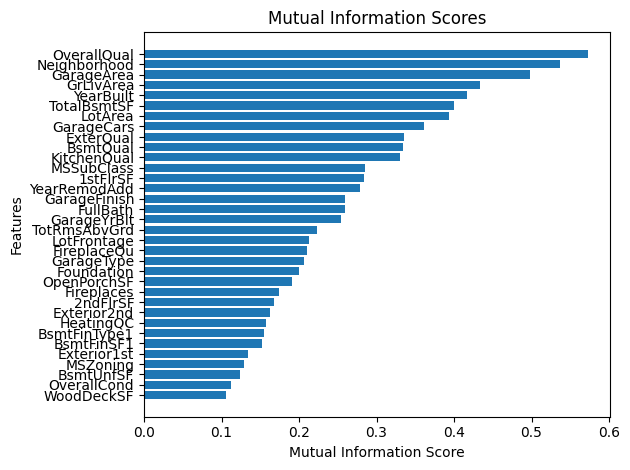

Index(['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
       'TotalBsmtSF', 'LotArea', 'GarageCars', 'ExterQual', 'BsmtQual',
       'KitchenQual', 'MSSubClass', '1stFlrSF', 'YearRemodAdd', 'GarageFinish',
       'FullBath', 'GarageYrBlt', 'TotRmsAbvGrd', 'LotFrontage', 'FireplaceQu',
       'GarageType', 'Foundation', 'OpenPorchSF', 'Fireplaces', '2ndFlrSF',
       'Exterior2nd', 'HeatingQC', 'BsmtFinType1', 'BsmtFinSF1', 'Exterior1st',
       'MSZoning', 'BsmtUnfSF', 'OverallCond', 'WoodDeckSF'],
      dtype='object')


In [8]:
from sklearn.cluster import KMeans

X = load_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')
correct_nan(X)
delete_noise(X, [1299, 524, 770, 636])#, 198, 314, 186, 247, 637]) #--> sono totalmente ingiustificati
X.reset_index(drop=True)

def handle_mi_scores(X,y):
    discrete_features = X.dtypes == int
#    print(discrete_features)
    def make_mi_scores(X, y, discrete_features):
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        return mi_scores
    
    mi_scores = make_mi_scores(X, y, discrete_features)
    mi_scores[::3]  # show a few features with their MI scores
    
    return mi_scores

y = X.pop('SalePrice')
label_encoders = {}

cat_features = [item for item in X.columns if X[item].dtype not in('int64','float64')]

for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

for col in cat_features:
    X[col].fillna(X[col].mode()[0], inplace=True)

scores = handle_mi_scores(X,y)

def plot_mi_scores(scores):
    # Assicurati che 'scores' sia in un formato corretto (Series o DataFrame)
    if not isinstance(scores, (pd.Series, pd.DataFrame)):
        raise ValueError("Input scores must be a pandas Series or DataFrame")
        
    scores = scores.sort_values(ascending=True)  # Ordina i punteggi
    width = np.arange(len(scores))  # Crea un array per le posizioni delle barre
    ticks = list(scores.index)  # Ottieni i nomi delle feature per le etichette delle y

    plt.barh(width, scores)  # Crea il grafico a barre orizzontali
    plt.yticks(width, ticks)  # Imposta le etichette delle y
    plt.title("Mutual Information Scores")  # Titolo del grafico
    plt.xlabel("Mutual Information Score")  # Etichetta asse x
    plt.ylabel("Features")  # Etichetta asse y
    plt.tight_layout()  # Ottimizza la disposizione del grafico
    plt.show()  # Mostra il grafico


plot_mi_scores(scores[scores>0.1])
print(scores[scores>0.1].index)

